In [2]:
!pip install apimoex -q


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import requests
import datetime
import pathlib
import apimoex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:
ticks = ['LKOH', 'GAZP', 'SBER', 'TATN', 
         'T', 'NVTK', 'GMKN', 'ROSN', 
         'YDEX', 'PLZL', 'SNGS', 'CHMF', 
         'NLMK', 'MOEX', 'HEAD'] # moex blue chips

board = 'TQBR'
period = ['2024-10-01', '2025-05-17'] # last half a year

## Скачиваем данные

На основе дат торговых дней создаю пустой датафрейм, куда потом будут добавляться все котировки. Далее итеративно скачиваются и добавляются котировки всех акций в заранее созданный для этого датафрейм. Новые данные добавляются при помощи inner join для того чтобы избежать конфликта индексации по датам (они могут отличаться). Таким образом, в конечном датасете есть только те дни, на которые существуют котировки всех акций.

In [3]:
def get_history(securities, start, end, board='TQBR'):
    """
    Fetches historical closing prices for specified securities from the Moscow Exchange (MOEX).
    
    Parameters:
        securities (list): List of security tickers.
        start, end (str): Start and end dates in 'YYYY-MM-DD' format.
        board (str): Trading board identifier. Defaults to 'TQBR' (Main Trading Board).

    Returns:
        pd.DataFrame: DataFrame with dates as index and columns as securities. 
                      Contains closing prices for dates where ALL securities have data.
    """
    
    # initializing empty dataframe where all prices are going to be dumped to
    hist_prices = pd.DataFrame(pd.date_range(start=start, end=end, freq='B')).set_index(0)
    
    with requests.Session() as session:
        # fetching historical data from MOEX ISS API for all securities consecutively
        for sec in securities:
            data = pd.DataFrame(
                apimoex.get_board_history(session=session, 
                                          security=sec, 
                                          board=board,
                                          start=start, 
                                          end=end
                                         ))[['TRADEDATE', 'CLOSE']]
            
            data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'], format='%Y-%m-%d')
            data.set_index('TRADEDATE', inplace=True)
            data.columns = [sec]
    
            # inner join, only keeps the trading dates for which all securities have prices
            hist_prices = pd.merge(hist_prices, data, left_index=True, right_index=True)
    
    return hist_prices.dropna()

In [4]:
blue_chips = get_history(ticks, period[0], period[1], board='TQBR')
blue_chips.head()

,LKOH,GAZP,SBER,TATN,T,NVTK,GMKN,ROSN,YDEX,PLZL,SNGS,CHMF,NLMK,MOEX,HEAD
2024-11-28,6905.5,120.29,228.56,534.3,2367.0,816.6,110.08,474.85,3365.5,14203.5,23.810,1095.8,124.00,183.88,4135
2024-11-29,6860.5,124.29,236.49,544.9,2387.8,835.6,112.96,478.00,3320.0,14124.5,23.965,1123.2,124.56,184.88,4159
2024-12-02,6810.0,123.90,235.17,548.5,2392.2,846.2,114.10,489.30,3434.0,14430.0,24.445,1142.8,124.68,191.76,4270
2024-12-03,6771.0,121.48,230.80,538.5,2352.0,824.0,110.40,490.50,3380.0,14512.5,23.615,1100.0,121.28,183.72,4233
2024-12-04,6720.5,115.30,224.55,521.6,2288.6,800.0,104.20,473.10,3252.0,14260.0,22.810,1058.0,118.70,179.90,4189


Как мы можем видеть, данные начинаются не с 2024-11-01, как я изначально указывал, а с 2024-11-28. Это связано с тем, что Т-банк сменил тикер своих акций, под которым они стали торговаться как раз 2024-11-28, до этого они обазначались не как T, а как TCSG.

## Корректируем на сплиты

In [5]:
def correct_splits(splits:dict, securities:pd.DataFrame):
    """
    Processes split events to ensure price continuity by scaling pre-split prices.
    
    Parameters:
        splits (dict): Split data in format {ticker: {split_date: split_ratio}}
            Example: {'AAAA': {'2000-01-01': 4}} for a 4:1 split
        securities (pd.DataFrame): DataFrame with historical prices where:
    Returns:
        pd.DataFrame: Adjusted historical prices with splits incorporated
    """
    security = securities.copy()
    for key, val in splits.items():
        split_date = pd.to_datetime(list(val.keys())[0]) + pd.DateOffset(-1)
        split_factor = 1 / list(val.values())[0]
        security.loc[:split_date, key] *= split_factor

        return security

In [6]:
splits = {'PLZL': {'2025-03-27': 10},
          }
blue_chips = correct_splits(splits, blue_chips)

blue_chips.loc['2025-03-20':].head()

,LKOH,GAZP,SBER,TATN,T,NVTK,GMKN,ROSN,YDEX,PLZL,SNGS,CHMF,NLMK,MOEX,HEAD
2025-03-20,7293.5,168.09,324.05,688.6,3632.4,1316.0,131.16,536.85,4646.0,1903.95,26.105,1322.8,159.36,215.24,3391
2025-03-21,7346.5,166.61,323.26,693.9,3605.0,1305.8,129.80,534.60,4625.0,1901.70,26.190,1311.0,157.02,213.09,3381
2025-03-27,7108.5,155.25,311.96,675.9,3398.8,1277.6,122.98,502.40,4446.0,1867.60,26.150,1199.2,143.10,202.40,3204
2025-03-28,7064.5,145.43,308.04,687.6,3304.0,1240.2,121.56,496.75,4357.0,1880.00,25.475,1153.2,142.26,198.74,3181
2025-03-31,7026.5,145.69,309.72,673.3,3365.4,1216.6,123.30,490.50,4476.0,1863.60,25.535,1188.0,144.58,199.55,3358


## Mean Variance Portfolio

Для начала посмотрим на нормализованные стоимости всех акций-голубых фишек 

<Axes: >

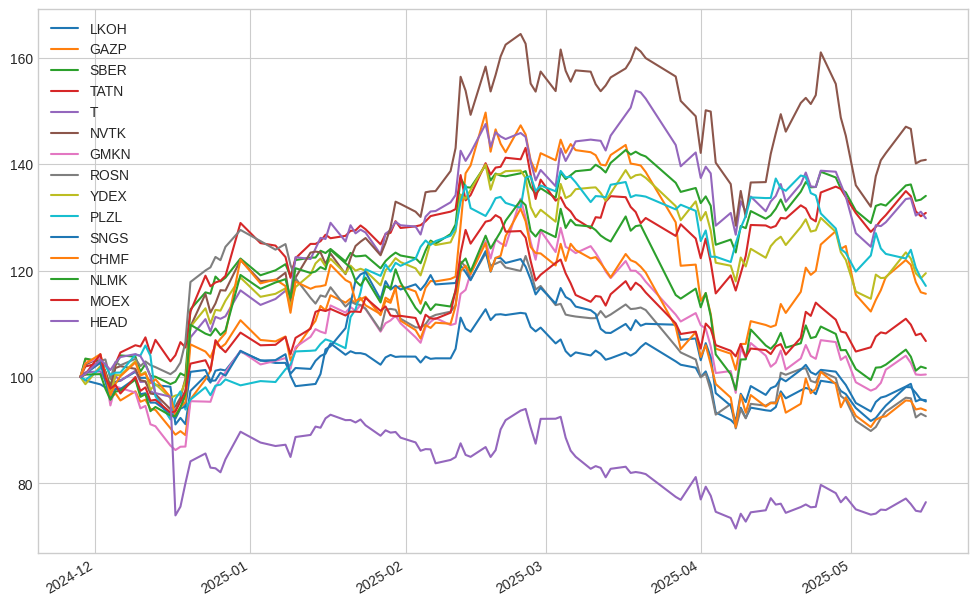

In [391]:
plt.style.use('seaborn-v0_8-whitegrid')

cum_returns = (blue_chips / blue_chips.iloc[0, :]) * 100
cum_returns.plot(figsize = [12, 8])

### Функционал

Для начала создадим вспомогательные функции

In [359]:
def get_returns(prices:pd.DataFrame):
    """Calculate daily logarithmic returns""" 
    return np.log(prices).diff().dropna()

def get_mean_cov(prices:pd.DataFrame, annual=True):
    """Calculate annualized (or daily) returns and covariance matrix"""
    
    returns = get_returns(prices)
    mean = returns.mean().values
    cov = returns.cov().values
    if annual:
        mean *= 252 # Annualize mean returns
        cov *= 252 # Annualize covariance
    return mean, cov

def get_random_portf(prices:pd.DataFrame, num=10000):
    """Generate random portfolios for visualization"""
    
    mean, cov = get_mean_cov(prices, True)
    # Using Dirichlet distribution to create a random (n x k) matrix with rows summing up to 1
    weights = np.random.dirichlet(np.ones(prices.shape[1]), size=num)

    portf_expect = mean @ weights.T # Expected returns
    
    # Using Einstein summation to skip matrix calculations, allows for O(nk^2) time
    portf_variance = np.sqrt(np.einsum('ij, jk, ik->i', weights, cov, weights)) # Expected volatility
    # This is also possible, but instead of directly calculating the portfolios variance,
    # it also calculates all their pairwise covariance and then takes diagonal elements (variances)
    #portf_variance = np.sqrt((weights @ cov @ weights.T).values.diagonal())

    return portf_expect, portf_variance

Функция `get_opt_portf` возвращет веса оптимального портфеля для заданной годовой доходности и заданных активов. Данная функция численно минимизирует функцию дисперсии портфеля по весам активов с ограниченями в виде: заданной доходности и нормализации весов (складываются в единицу).

Функция `get_eff_frontier` возвращает ожидаемую дохондсоть и ожидаемую волатильность. Функция создает вектор между минимальными и максимальными средними значениями доходности. Затем для каждого элемента этого вектора рассчитываются веса оптимального портфеля, а для них ожидаемая доходность и волатильность.

In [411]:
def get_opt_portf(target_return, prices:pd.DataFrame):
    """Optimize portfolio for given target return"""
    
    mean, cov = get_mean_cov(prices, True)
    n_assets = prices.shape[1]
    
    # Optimization scipy.opt setup
    bounds = tuple((0, 1) for _ in range(n_assets))
    init_w = np.ones(n_assets) / n_assets
    
    constraints = [
        {'type': 'eq', 'fun': lambda w: w @ mean - target_return * 2}, # Return constraint
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1} # Fully invested constraint
    ]
    # Optimizes variance directly
    result_opt = opt.minimize(
        fun=lambda w: w @ cov @ w.T, # Portfolio variance
        x0=init_w, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    return result_opt.x

def get_eff_frontier(prices:pd.DataFrame, num_points=100):
    """Calculate efficient frontier"""
    mean, cov = get_mean_cov(prices, True)
    
    # Find feasible return range
    min_return = mean.min()
    max_return = mean.max()
    targets = np.linspace(min_return, max_return, num_points)
    
    frontier_returns = []
    frontier_volatility = []
    for target in targets:
        weights = get_opt_portf(target, prices)
        if weights is not None:
            frontier_returns.append(weights @ mean)
            frontier_volatility.append(np.sqrt(weights @ cov @ weights.T))

    return frontier_returns, frontier_volatility

### Граница эффективности

In [412]:
rand_return, rand_volatility = get_random_portf(blue_chips) 
front_return, front_volatility = get_eff_frontier(blue_chips)

Нарисуем график симулированных портфелей и границы эффективности

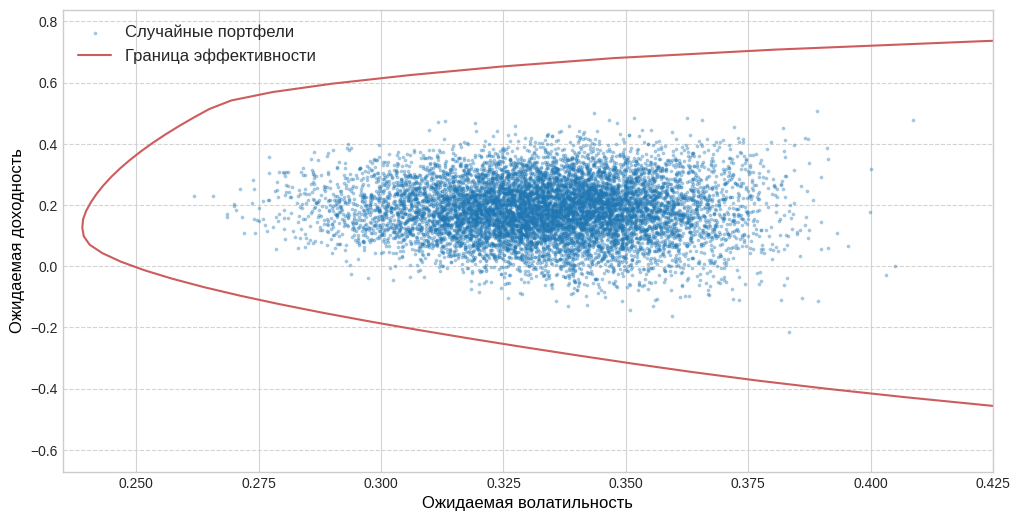

In [413]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = [12, 6])

plt.scatter(rand_volatility, rand_return, s=3, label='Случайные портфели', c='C0', alpha=0.3)
plt.plot(front_volatility, front_return, color='indianred', label='Граница эффективности')

plt.xlabel('Ожидаемая волатильность', fontsize = 12, color='black')
plt.ylabel('Ожидаемая доходность', fontsize = 12, color='black')
plt.xlim(.235, .425)
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')

plt.legend(fontsize=12)

### Оценка динамики разнообразных портфелей

Оценим динамику разных портфелей

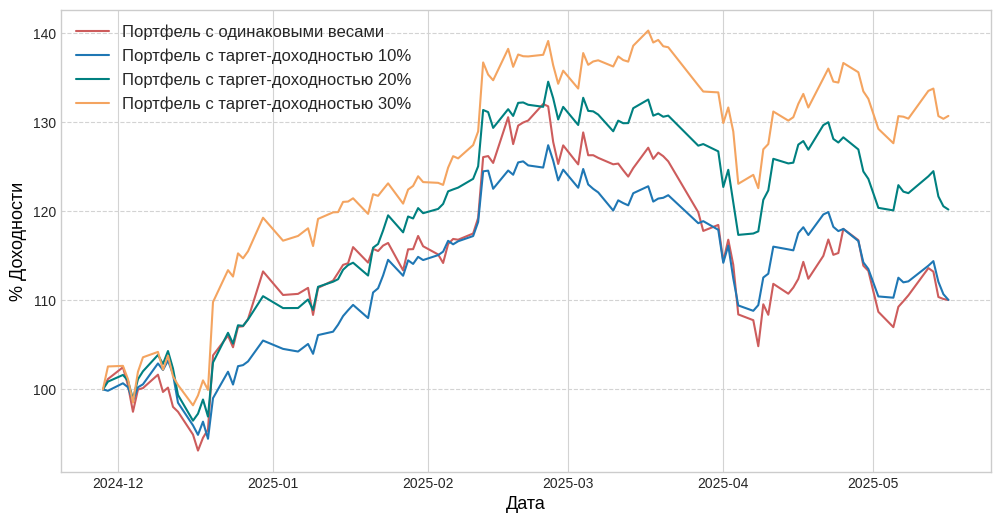

In [424]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = [12, 6])

equal_weights = np.ones(blue_chips.shape[1]) / blue_chips.shape[1]
low_yield_weights = get_opt_portf(0.1 , blue_chips)
middle_yield_weights = get_opt_portf(0.2 , blue_chips)
high_yield_weights = get_opt_portf(0.3 , blue_chips)



plt.plot(cum_returns @ equal_weights, label='Портфель с одинаковыми весами', c='indianred')
plt.plot(cum_returns @ low_yield_weights, label='Портфель с таргет-доходностью 10%', c='C0')
plt.plot(cum_returns @ middle_yield_weights, label='Портфель с таргет-доходностью 20%', c='teal')
plt.plot(cum_returns @ high_yield_weights, label='Портфель с таргет-доходностью 30%', c='sandybrown')

plt.xlabel('Дата', fontsize = 13, color='black')
plt.ylabel('% Доходности', fontsize = 13, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')

plt.legend(fontsize=12)